In this project, I tried to predict the rating based on products' reviews. 

In [17]:
import gzip
import string
from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import clear_output
import string
import random
import math
import ast
import numpy as np
import json

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
import sklearn.preprocessing


In [3]:
def parse(file):
#     total_count = 0
    keep = 0
    withdraw = 0
    for l in gzip.open(file):
        l = l.replace(b'true', b'True') # all data read from the file is returned as bytes
        l = l.replace(b'false', b'False')
        item = eval(l)
        year = int(item['reviewTime'].split(',')[1])
        if year > 2010 and item['verified'] and 'reviewText' in item.keys():
            keep += 1
            
            yield item
        else:
            withdraw += 1
        
        clear_output(wait=True)
        print(keep+withdraw, keep, withdraw)
        if keep == 70000: break
        

In [4]:
dataset = list(parse("Grocery_and_Gourmet_Food_5.json.gz"))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
print(dataset[50000])

{'overall': 5.0, 'verified': True, 'reviewTime': '04 7, 2012', 'reviewerID': 'AOP5TUC7TTEY0', 'asin': 'B000E48IMO', 'style': {'Size:': ' 10.6 Ounce (Pack of 6)', 'Flavor:': ' Mesa Sunrise'}, 'reviewerName': 'J', 'reviewText': "This is my favorite gluten free cereal. Good ingredients, flavor and texture. Only negative is that the price on Amazon isn't much below the local health food store, and much higher when it's on sale at the store at 2.99.", 'summary': 'Cereal', 'unixReviewTime': 1333756800}


In [6]:
print(len(dataset))

70000


### Data Distribution Visaulization

In [28]:
rating_count = defaultdict(int)
reviewer = defaultdict(int)
review_count_year = defaultdict(int) # number of reviews in each year
asin = set()
ave_review_length = 0
ave_rating = 0
ave_rating_year = defaultdict(int)
count_reviewText = 0

# rating count
for d in dataset:
    rating_count[d['overall']] += 1
    ave_rating += d['overall']
    if 'reviewText' in d.keys(): # not every item has key 'reviewText'
        count_reviewText += 1
        ave_review_length += len(d['reviewText']) 
    reviewer[d['reviewerID']] += 1
    asin.add(d['asin'])
    
    # number of reviews in each year
    year = d['reviewTime'].split(',')[1].strip()
    review_count_year[year] += 1
    
    ave_rating_year[year] += d['overall']
    
# count average year rating 
for k in ave_rating_year.keys():
    ave_rating_year[k] = ave_rating_year[k]/review_count_year[k]
    
# sort dictionay
rating_count = [(r, c) for r, c in sorted(rating_count.items(), key=lambda i:i[0])]
sorted_reviewer = [(r, c) for r, c in sorted(reviewer.items(), key = lambda i:i[1], reverse = True)]
sorted_review_count_year = [(y,n) for y,n in sorted(review_count_year.items(), key = lambda i:int(i[0]))]
sorted_ave_rating_year = [(y,r) for y,r in sorted(ave_rating_year.items(), key = lambda i:int(i[0]))]

# average rating
ave_rating = ave_rating / len(dataset)
ave_review_length = ave_review_length / len(dataset)

print("Rating count:", rating_count)
print("Average rating:", ave_rating)
print("Number of reviewer:", len(reviewer))
print("Number of music:", len(asin))
print("Average review length:", ave_review_length)
print("reviewText:", count_reviewText)
print("Number of reviews in each year", sorted_review_count_year)
print("Average rating of each year:", sorted_ave_rating_year)

Rating count: [(1.0, 2304), (2.0, 2045), (3.0, 4200), (4.0, 8487), (5.0, 52964)]
Average rating: 4.539457142857143
Number of reviewer: 44186
Number of music: 1820
Average review length: 174.21231428571429
reviewText: 70000
Number of reviews in each year [('2011', 1750), ('2012', 2662), ('2013', 7878), ('2014', 12720), ('2015', 17591), ('2016', 14490), ('2017', 9965), ('2018', 2944)]
Average rating of each year: [('2011', 4.386285714285714), ('2012', 4.412847483095417), ('2013', 4.5053313023610055), ('2014', 4.5158018867924525), ('2015', 4.581774771189813), ('2016', 4.5822636300897175), ('2017', 4.5257400903161065), ('2018', 4.521399456521739)]


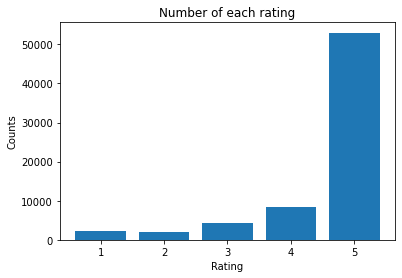

In [69]:
plt.bar(range(1,6), [i[1] for i in rating_count])
plt.xticks(range(1,6))
plt.xlabel("Rating")
plt.ylabel("Counts")
plt.title("Number of each rating")
plt.show()

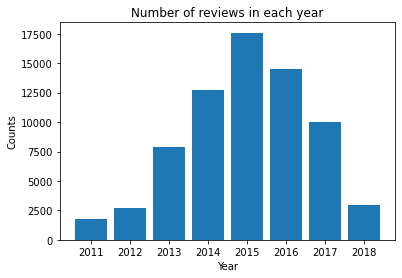

In [70]:
plt.bar([i[0] for i in sorted_review_count_year], [i[1] for i in sorted_review_count_year])
plt.xlabel("Year")
plt.ylabel("Counts")
plt.title("Number of reviews in each year")
plt.show()

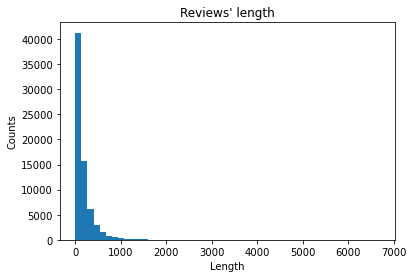

In [78]:
# fig, axs = plt.subplots(1, 2, figsize = (12,5))

plt.hist([len(i['reviewText']) for i in dataset], bins=50)
plt.xlabel("Length")
plt.ylabel("Counts")
plt.title("Reviews' length")
plt.show()

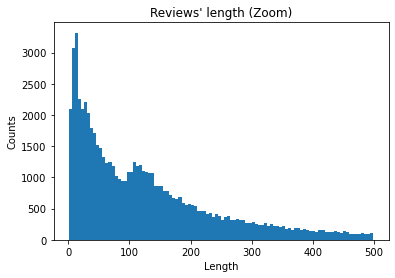

In [77]:
plt.hist([len(i['reviewText']) for i in dataset if len(i['reviewText'])<500 ], bins=100)
plt.xlabel("Length")
plt.ylabel("Counts")
plt.title("Reviews' length (Zoom)")
plt.show()

In [139]:
# import positive and negative from Opinion Lexicon
#
positive_bank, negative_bank = [], []
for l in open('positive-words.txt', encoding = "ISO-8859-1"):
    positive_bank.append(l.replace('\n', ''))

for l in open('negative-words.txt', encoding = "ISO-8859-1"):
    negative_bank.append(l.replace('\n', ''))
    
#positive words from reviews
positive_words, negative_words = defaultdict(int), defaultdict(int)

c = 0
for d in dataset:
#     in_target = False
    words = ''.join([c for c in d['reviewText'] if c not in string.punctuation])
    words = words.replace('\n', '')
    if d['overall'] >= 3: 
        for w in words.split():
            if w in positive_bank:
                positive_words[w] += 1
    else:
        for w in words.split():
            if w in negative_bank:
                negative_words[w] += 1
    # print processing status            
    c +=1
    if c%100 == 0:
        clear_output(wait=True)
        print(c)
# positive_words_list = [(w, c/len(positive_words)) for w, c in sorted(positive_words.items(), key = lambda i:i[1], reverse = True)]
# negative_words_list = [(w, c/len(negative_words)) for w, c in sorted(negative_words.items(), key = lambda i:i[1], reverse = True)]

70000


In [140]:
positive_words_list = [(w, c/len(positive_words)) for w, c in sorted(positive_words.items(), key = lambda i:i[1], reverse = True)]
negative_words_list = [(w, c/len(negative_words)) for w, c in sorted(negative_words.items(), key = lambda i:i[1], reverse = True)]
print(positive_words_list[:20])
print(negative_words_list[:20])
print(", ".join([i[0] for i in positive_words_list[:20]]))
print(", ".join([i[0] for i in negative_words_list[:20]]))

[('good', 14.383848454636091), ('like', 12.211365902293121), ('great', 11.084745762711865), ('love', 8.497507477567298), ('best', 4.0667996011964105), ('better', 3.7387836490528414), ('favorite', 3.7328015952143567), ('well', 3.5832502492522433), ('delicious', 3.1056829511465605), ('nice', 3.032901296111665), ('fresh', 2.748753738783649), ('hot', 2.4277168494516452), ('sweet', 2.419740777666999), ('free', 2.15752741774676), ('recommend', 1.9700897308075773), ('perfect', 1.7587238285144566), ('easy', 1.7477567298105683), ('right', 1.6600199401794615), ('strong', 1.6331006979062812), ('wonderful', 1.53938185443669)]
[('bad', 0.44149577804583834), ('disappointed', 0.33775633293124246), ('hard', 0.23642943305186973), ('stale', 0.21109770808202655), ('smell', 0.16646562123039807), ('awful', 0.16284680337756333), ('waste', 0.15078407720144751), ('weak', 0.13148371531966224), ('bland', 0.12545235223160434), ('bitter', 0.12303980699638119), ('terrible', 0.11942098914354644), ('expensive', 0.11

In [144]:
posi, nega = [], []
c = 0
for d in dataset:
    words = ''.join([c for c in d['reviewText'] if c not in string.punctuation])
    words = words.replace('\n', '')

    for w in words.split():
        if w in positive_bank:
            posi.append(w)

    for w in words.split():
        if w in negative_bank:
            nega.append(w)
      
    c +=1
    if c%100 == 0:
        clear_output(wait=True)
        print(c)

70000


In [149]:
f = open('postive_list.txt', 'w')
f.write(', '.join(posi))
f.close()

In [164]:
pn, parsed_text = [], []
for d in dataset:
    words = ''.join([c for c in d['reviewText'] if c not in string.punctuation])
    words = words.replace('\n', '')
    if d['overall'] >= 4:
        pn.append('positive')
    else:
        pn.append('negative')
    parsed_text.append(str(words.split()))
    
f1 = open('pn.txt', 'w')
f2 = open('parse_text.txt', 'w')
for i in range(len(pn)):
    f1.write(pn[i] + '\n')
    f2.write(str(parsed_text[i]) + '\n')
f1.close()
f2.close()

In [163]:
print(parsed_text[:5])

["['I', 'have', 'had', 'vocal', 'cord', 'issues', 'for', 'nearly', 'a', 'year', 'and', 'this', 'tea', 'with', 'neck', 'and', 'vocal', 'exercises', 'have', 'worked', 'wonders']", "['A', 'great', 'cracker', 'and', 'super', 'snack', 'any', 'time', 'of', 'the', 'day', 'Sometimes', 'I', 'even', 'have', 'for', 'lunch', 'and', 'it', 'fills', 'me', 'up', 'A', 'snack', 'thats', 'totally', 'organic', 'and', 'tastes', 'wonderful']", "['This', 'is', 'working', 'OK', 'I', 'really', 'like', 'the', 'Vanilla', 'Extract', 'from', 'Costco', 'that', 'usually', 'costs', 'around', '7', 'but', 'is', 'now', '30', 'So', 'this', 'is', 'a', 'good', 'replacement', 'for', 'the', 'time', 'being']", "['Nice', 'but', 'i', 'like', 'the', 'bigger', 'sea', 'salt', 'better', 'thank', 'you']", "['great', 'tea']"]


### Data Preprocessing

In [82]:
ori_dataset = dataset

In [83]:
shuffle_dataset = ori_dataset
random.shuffle(shuffle_dataset)


In [88]:
# store 70000 sample to txt
f = open('final_dataset.txt', 'w')
c = 0
for d in shuffle_dataset:
    f.write(str(d) + '\n')
    c+= 1
    if c%100 == 0:
        clear_output(wait=True)
        print(c)
f.close()
print('finish store')

70000
finish store


In [30]:
# load 70000 data from txt file
dataset = []
c = 0
for l in open('final_dataset.txt'):
# for l in f.readline():
    if len(l) == 0:
        print("zero")
        break
    c +=1
    dataset.append(eval(l))
    if c%100 == 0:
        clear_output(wait=True)
        print(c)
clear_output(wait=True)
print(c)

70000


In [31]:
# split data into train, val, test set
train_set = dataset[:50000] 
validation_set = dataset[50000:60000] 
test_set = dataset[60000:] 

### Features extraction

In [33]:
# top 1000 words for unigram and bigram using train_set
unigram = defaultdict(int)
bigram = defaultdict(int)

for d in train_set:
    words = d['reviewText'].replace('\n', '').strip()
    words = ''.join([c for c in words if c not in string.punctuation])
    words = words.split()
    for i in range(len(words)):
        unigram[words[i]] += 1
        
    for i in range(len(words)-1):
        bigram[words[i] + ' ' + words[i+1]] += 1

unigram_list = [w for w in sorted(unigram.items(), key = lambda i:i[1], reverse = True)]
bigram_list = [w for w in sorted(bigram.items(), key = lambda i:i[1], reverse = True)]

unigram_top_words = [w[0] for w in unigram_list[:1000]]
bigram_top_words = [w[0] for w in bigram_list[:1000]]

unigram_top_wordsId = dict(zip(unigram_top_words, range(len(unigram_top_words))))
bigram_top_wordsId = dict(zip(bigram_top_words, range(len(bigram_top_words))))

In [167]:
print(unigram_top_words[:100])

['I', 'the', 'and', 'a', 'to', 'it', 'is', 'of', 'this', 'for', 'in', 'tea', 'my', 'with', 'but', 'that', 'have', 'good', 'you', 'not', 'as', 'like', 'are', 'on', 'was', 'great', 'taste', 'so', 'flavor', 'This', 'or', 'love', 'The', 'these', 'them', 'very', 'be', 'just', 'It', 'product', 'use', 'they', 'at', 'one', 'all', 'me', 'can', 'more', 'its', 'will', 'has', 'from', 'than', 'Great', 'price', 'when', 'make', 'really', 'buy', 'if', 'much', 'get', 'other', 'some', 'out', 'had', 'time', 'too', 'dont', 'would', 'little', 'best', 'no', 'up', 'better', 'find', 'an', 'My', 'favorite', 'again', 'am', 'Its', 'about', 'only', 'Im', 'sugar', 'well', 'Ive', 'your', 'because', 'used', 'do', 'what', 'coffee', 'been', 'also', 'were', 'which', 'salt', 'nice']


In [ ]:
# top 1000 words for unigram and bigram using val_set
# unigram_val = defaultdict(int)
# bigram_val = defaultdict(int)
# for d in val_set:
#     words = d['reviewText'].replace('\n', '').strip()
#     words = ''.join([c for c in words if c not in string.punctuation])
#     words = words.split()
#     for i in range(len(words)):
#         unigram_val[words[i]] += 1
        
#     for i in range(len(words)-1):
#         bigram_val[words[i] + ' ' + words[i+1]] += 1

# unigram_val_list = [w for w in sorted(unigram_val.items(), key = lambda i:i[1], reverse = True)]
# bigram_val_list = [w for w in sorted(bigram_val.items(), key = lambda i:i[1], reverse = True)]

# unigram_val_top_words = [w[0] for w in unigram_val_list[:1000]]
# bigram_val_top_words = [w[0] for w in bigram_val_list[:1000]]

# unigram_top_wordsId = dict(zip(unigram_top_words, range(len(unigram_top_words))))
# bigram_top_wordsId = dict(zip(bigram_top_words, range(len(bigram_top_words))))

In [34]:
# calculate idf
unigram_idf = [math.log(100000/x[1], 10) for x in unigram_list[:1000]]
bigram_idf = [math.log(100000/x[1], 10) for x in bigram_list[:1000]]

#### Training set

In [169]:
# data preprocessing # extract feature 
#train_set #unigram #bigram

X_train_uni, y_train = [], []
X_train_bi = []

c = 0
for d in train_set:
    c += 1
    #unigram
    feat = []
    for w in unigram_top_words:
        feat.append(d['reviewText'].count(w))
    feat.append(1)
    X_train_uni.append(feat)
    y_train.append(d['overall'])
    
    #bigram
    feat = []
    for w in bigram_top_words:
        line = d['reviewText'].replace('\n', '')
#         line = ''.join([c for c in line if c not in string.punctuation])
        for p in string.punctuation:
            line = line.replace(p, '')
        feat.append(line.count(w))
    feat.append(1)
    X_train_bi.append(feat)
    
    if c % 10 == 0:
        clear_output(wait=True)
        print("Processing progress:", c ,"/50000")


Processing progress: 50000 /50000


In [170]:
#store training set to .txt file 
# f = open('train_wordbag.txt','w')
# f.write(str(X_train_uni) + '\n')
# f.write(str(X_train_bi) + '\n')
# f.write(str(y_train) + '\n')
# f.close()

In [3]:
# load data from .txt file
import json
# f = open('train_wordbag.txt','r')
# X_train_uni = json.loads(f.readline())
# X_train_bi = json.loads(f.readline())
# y_train = json.loads(f.readline())
# f.close()


In [172]:
# data preprocessing 
# calculate tfidf for train_set
X_train_uni_tfidf, X_train_bi_tfidf = [], []
c = 0
for d in train_set:
    c += 1
    feat = []
    for i in range(len(unigram_top_words)):
        tfidf = d['reviewText'].count(unigram_top_words[i]) * unigram_idf[i]
        feat.append(tfidf)
    feat.append(1)
    X_train_uni_tfidf.append(feat)
    
    #bigram
    feat = []
    for i in range(len(bigram_top_words)):
        line = d['reviewText'].replace('\n', '')
        for p in string.punctuation:
            line = line.replace(p, '')
        tfidf = line.count(bigram_top_words[i]) * bigram_idf[i]
        feat.append(tfidf)
    feat.append(1)
    X_train_bi_tfidf.append(feat)
    
    if c % 10 == 0:
        clear_output(wait=True)
        print("Processing progress:", c ,"/50000")



Processing progress: 50000 /50000


In [173]:
#store training set feature to txt file 
#bigram #unigram #tfidf
f = open('train_wordbag.txt','w')
f.write(str(X_train_uni) + '\n')
f.write(str(X_train_bi) + '\n')
f.write(str(y_train) + '\n')
f.close()

f = open('train_tfidf.txt','w')
f.write(str(X_train_uni_tfidf) + '\n')
f.write(str(X_train_bi_tfidf) + '\n')
f.write(str(y_train) + '\n')
f.close()
print("finish storing...")

finish storing...


In [19]:
f = open('train_wordbag.txt','r')
X_train_uni = json.loads(f.readline())
X_train_bi = json.loads(f.readline())
y_train = json.loads(f.readline())
f.close()

f = open('train_tfidf.txt','r')
X_train_uni_tfidf = json.loads(f.readline())
X_train_bi_tfidf = json.loads(f.readline())
f.close()

#### Normalize training set

In [20]:
X_train_uni = np.array(X_train_uni)
X_train_bi = np.array(X_train_bi)
y_train = np.array(y_train )
X_train_uni_tfidf = np.array(X_train_uni_tfidf)
X_train_bi_tfidf = np.array(X_train_bi_tfidf)

X_train_uni = sklearn.preprocessing.normalize(X_train_uni)
X_train_bi = sklearn.preprocessing.normalize(X_train_bi)
X_train_uni_tfidf = sklearn.preprocessing.normalize(X_train_uni_tfidf)
X_train_bi_tfidf = sklearn.preprocessing.normalize(X_train_bi_tfidf)

#### Validation set

In [35]:
# data preprocessing 
# extract feature for validation set
# unigram #bigram
X_val_uni, y_val = [], []
X_val_bi = []

c = 0
for d in validation_set:
    c += 1
    #unigram
    feat = []
    for w in unigram_top_words:
        feat.append(d['reviewText'].count(w))
    feat.append(1)
    X_val_uni.append(feat)
    y_val.append(d['overall'])
    
    #bigram
    feat = []
    for w in bigram_top_words:
        line = d['reviewText'].replace('\n', '')
        for p in string.punctuation:
            line = line.replace(p, '')
        feat.append(line.count(w))
    feat.append(1)
    X_val_bi.append(feat)
    
    if c % 10 == 0:
        clear_output(wait=True)
        print("Processing progress:", c ,"/10000")

Processing progress: 10000 /10000


In [36]:
# data preprocessing 
# calculate tfidf for val_set
X_val_uni_tfidf, X_val_bi_tfidf = [], []
c = 0
for d in validation_set:
    c += 1
    feat = []
    for i in range(len(unigram_top_words)):
        tfidf = d['reviewText'].count(unigram_top_words[i]) * unigram_idf[i]
        feat.append(tfidf)
    feat.append(1)
    X_val_uni_tfidf.append(feat)
    
    #bigram
    feat = []
    for i in range(len(bigram_top_words)):
        line = d['reviewText'].replace('\n', '')
        for p in string.punctuation:
            line = line.replace(p, '')
        tfidf = line.count(bigram_top_words[i]) * bigram_idf[i]
        feat.append(tfidf)
    feat.append(1)
    X_val_bi_tfidf.append(feat)
    
    if c % 10 == 0:
        clear_output(wait=True)
        print("Processing progress:", c ,"/10000")



Processing progress: 10000 /10000


In [37]:
# store validation set feature to txt file 
f = open('val_wordbag.txt','w')
f.write(str(X_val_uni) + '\n')
f.write(str(X_val_bi) + '\n')
f.write(str(y_val) + '\n')
f.close()

f = open('val_tfidf.txt','w')
f.write(str(X_val_uni_tfidf) + '\n')
f.write(str(X_val_bi_tfidf) + '\n')
f.write(str(y_val) + '\n')
f.close()

In [40]:
# load
f = open('val_wordbag.txt','r')
X_val_uni = json.loads(f.readline())
X_val_bi = json.loads(f.readline())
y_val = json.loads(f.readline())
f.close()

f = open('val_tfidf.txt','r')
X_val_uni_tfidf = json.loads(f.readline())
X_val_bi_tfidf = json.loads(f.readline())
f.close()

#### Normalization

In [41]:
X_val_uni = np.array(X_val_uni)
X_val_bi = np.array(X_val_bi)
y_val = np.array(y_val)
X_val_uni_tfidf = np.array(X_val_uni_tfidf)
X_val_bi_tfidf = np.array(X_val_bi_tfidf)

X_val_uni = sklearn.preprocessing.normalize(X_val_uni)
X_val_bi = sklearn.preprocessing.normalize(X_val_bi)
X_val_uni_tfidf = sklearn.preprocessing.normalize(X_val_uni_tfidf)
X_val_bi_tfidf = sklearn.preprocessing.normalize(X_val_bi_tfidf)

#### Extract features from test set

In [190]:
X_test_uni, X_test_bi = [], []
X_test_uni_tfidf, X_test_bi_tfidf = [], []
y_test = []

c = 0
for d in test_set:
    c += 1
    #unigram_wordbag
    feat = []
    for w in unigram_top_words:
        feat.append(d['reviewText'].count(w))
    feat.append(1)
    X_test_uni.append(feat)
    y_test.append(d['overall'])
    
    #bigram_wordbag
    feat = []
    for w in bigram_top_words:
        line = d['reviewText'].replace('\n', '')
        for p in string.punctuation:
            line = line.replace(p, '')
        feat.append(line.count(w))
    feat.append(1)
    X_test_bi.append(feat)
    
    #unigram_tfidf
    feat = []
    for i in range(len(unigram_top_words)):
        tfidf = d['reviewText'].count(unigram_top_words[i]) * unigram_idf[i]
        feat.append(tfidf)
    feat.append(1)
    X_test_uni_tfidf.append(feat)
    
    #bigram_tfidf
    feat = []
    for i in range(len(bigram_top_words)):
        line = d['reviewText'].replace('\n', '')
        for p in string.punctuation:
            line = line.replace(p, '')
        tfidf = line.count(bigram_top_words[i]) * bigram_idf[i]
        feat.append(tfidf)
    feat.append(1)
    X_test_bi_tfidf.append(feat)
    
    if c % 10 == 0:
        clear_output(wait=True)
        print("Processing progress:", c ,"/10000")

Processing progress: 10000 /10000


In [191]:
#store test set to .txt
f = open('test_wordbag.txt','w')
f.write(str(X_test_uni) + '\n')
f.write(str(X_test_bi) + '\n')
f.write(str(y_test) + '\n')
f.close()

f = open('test_tfidf.txt','w')
f.write(str(X_test_uni_tfidf) + '\n')
f.write(str(X_test_bi_tfidf) + '\n')
f.write(str(y_test) + '\n')
f.close()

In [15]:
# load test set from .txt
f = open('test_wordbag.txt','r')
X_test_uni = json.loads(f.readline())
X_test_bi = json.loads(f.readline())
y_test = json.loads(f.readline())
f.close()

f = open('test_tfidf.txt','r')
X_test_uni_tfidf = json.loads(f.readline())
X_test_bi_tfidf = json.loads(f.readline())
# y_test = json.loads(f.readline())
f.close()

#### Normalize test set

In [16]:
X_test_uni = np.array(X_test_uni)
X_test_bi = np.array(X_test_bi)
y_test = np.array(y_test)

X_test_uni_tfidf = np.array(X_test_uni_tfidf)
X_test_bi_tfidf = np.array(X_test_bi_tfidf )

X_test_uni = sklearn.preprocessing.normalize(X_test_uni)
X_test_bi = sklearn.preprocessing.normalize(X_test_bi)
X_test_uni_tfidf = sklearn.preprocessing.normalize(X_test_uni_tfidf)
X_test_bi_tfidf = sklearn.preprocessing.normalize(X_test_bi_tfidf)

#### Evaluation Method

In [10]:
# accuracy
def accuracy(y_pred, y):
    return sum([True for i in range(len(y)) if y_pred[i] == y[i]])/len(y)

In [ ]:
#confusion matrix

## MODEL

### 1. KNN

#### 1.1 KNN/unigram/word bag

In [23]:
# training
knn_uni = KNeighborsClassifier(n_neighbors=5)
knn_uni_classifier = knn_uni.fit(X_train_uni, y_train)

In [94]:
y_pred = knn_uni.predict(X_train_uni)
print(accuracy(y_pred, y_train))

0.78586


In [200]:
# validation
y_pred = knn_uni.predict(X_val_uni)
print(accuracy(y_pred, y_val))

0.7264


In [24]:
# testing # accuracy
y_pred = knn_uni.predict(X_test_uni)
print(accuracy(y_pred, y_test))

0.7138


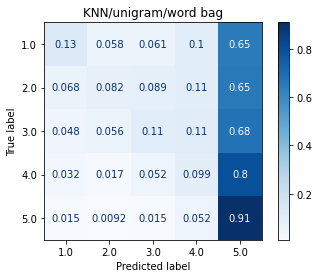

In [26]:
# confusion matrix
disp = plot_confusion_matrix(knn_uni_classifier, X_test_uni, y_test,
                             cmap=plt.cm.Blues,
                             normalize = 'true')
plt.title('KNN/unigram/word bag')
plt.show()

#### 1.2 KNN/bigram/word bag

In [42]:
# training
print("start training")
knn_bi = KNeighborsClassifier(n_neighbors=5)
knn_bi_classifier = knn_bi.fit(X_train_bi, y_train)

start training


In [93]:
y_pred = knn_bi.predict(X_train_bi)
print(accuracy(y_pred, y_train))

0.78286


In [43]:
# validation
print("start validating")
y_pred = knn_bi.predict(X_val_bi)
print(accuracy(y_pred, y_val))

start validating
0.7302


In [44]:
# testing
y_pred = knn_uni.predict(X_test_bi)
print(accuracy(y_pred, y_test))

0.7013


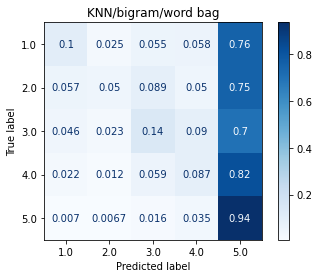

In [45]:
#confusion matriix
disp = plot_confusion_matrix(knn_bi_classifier, X_test_bi, y_test, 
                             cmap=plt.cm.Blues,
                             normalize = 'true')
plt.title('KNN/bigram/word bag')
plt.show()

#### 1.3 KNN/unigram/tfidf

In [46]:
 #training
knn_uni_tfidf = KNeighborsClassifier(n_neighbors=5)
knn_uni_tfidf_classifier = knn_uni_tfidf.fit(X_train_uni_tfidf, y_train)

In [ ]:
y_pred = knn_uni_tfidf.predict(X_train_uni_tfidf)
print(accuracy(y_pred, y_train))

In [47]:
# validation
y_pred = knn_uni_tfidf.predict(X_val_uni_tfidf)
print(accuracy(y_pred, y_val))

0.724


In [48]:
# testing
y_pred = knn_uni.predict(X_test_uni_tfidf)
print(accuracy(y_pred, y_test))

0.72


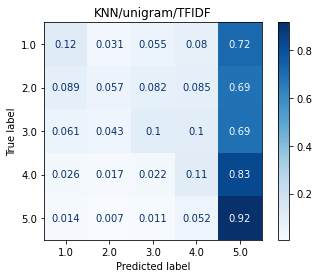

In [49]:
disp = plot_confusion_matrix(knn_uni_tfidf_classifier, X_test_uni_tfidf, y_test, 
                             cmap=plt.cm.Blues, 
                             normalize = 'true')
plt.title('KNN/unigram/TFIDF')
plt.show()

#### 1.4 KNN/bigram/tfidf

In [50]:
# training
knn_bi_tfidf = KNeighborsClassifier(n_neighbors=5)
knn_bi_tfidf_classifier = knn_bi_tfidf.fit(X_train_bi_tfidf, y_train)

In [92]:
y_pred = knn_bi_tfidf.predict(X_train_bi_tfidf)
print(accuracy(y_pred, y_train))

0.78318


In [51]:
# validation
y_pred = knn_bi_tfidf.predict(X_val_bi_tfidf)
print(accuracy(y_pred, y_val))

0.7302


In [52]:
# testing and accuracy
y_pred = knn_uni.predict(X_test_bi_tfidf)
print(accuracy(y_pred, y_test))

0.6788


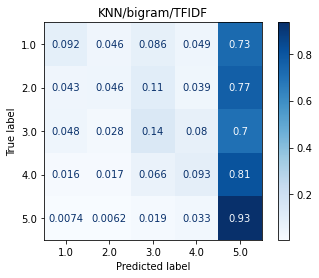

In [91]:
# confusion matrix
disp = plot_confusion_matrix(knn_bi_tfidf_classifier, X_test_bi_tfidf, y_test, 
                             cmap=plt.cm.Blues,
                             normalize = 'true')
plt.title('KNN/bigram/TFIDF')
plt.show()

### 2. Logistic Regress

#### 2.1 Logistic Regression/unigram/word bag

In [64]:
# training 
lr_uni = LogisticRegression(C=100, max_iter=2000)
clf_uni = lr_uni.fit(X_train_uni, y_train)
y_train_pred = lr_uni.predict(X_train_uni)
print(accuracy(y_train_pred, y_train))

0.79002


In [65]:
# validation
# c=100 0.6983 solver = 'saga'
# c=1 0.6983 solver = 'saga'
# c=100 0.7106
# c = 100 0.7154 max_iter=200
# c = 100 0.7169 max_iter=500
# c = 10 0.7188 nax_iter= 800
# c = 10 nax_iter= 1000 0.74232 .7193 0.7264

y_val_pred = lr_uni.predict(X_val_uni)
print(accuracy(y_val_pred, y_val))

0.7776


In [66]:
# testing
y_test_pred = lr_uni.predict(X_test_uni)
print(accuracy(y_test_pred, y_test))

0.7773


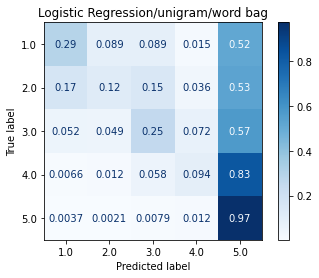

In [67]:
# confusion matrix
disp = plot_confusion_matrix(clf_uni, X_test_uni, y_test, 
                             cmap=plt.cm.Blues,
                             normalize = 'true')
plt.title('Logistic Regression/unigram/word bag')
plt.show()

#### 2.2Logistic Regression/bigram/word bag

In [68]:
# training
lr_bi = LogisticRegression(C=100, max_iter=2000)
clf_bi = lr_bi.fit(X_train_bi, y_train)
y_train_pred = clf_bi.predict(X_train_bi)
print(accuracy(y_train_pred, y_train))

0.78184


In [69]:
# validation
# c = 10 max_iter = 1000 0.72616 0.7021 0.7042
# C = 1  max_iter = 1000 0.72636 0.7017 0.7036
# C = 0.1 max_iter = 1000 0.72034 0.707 0.7055
y_val_pred = lr_bi.predict(X_val_bi)
print(accuracy(y_val_pred , y_val))

0.766


In [71]:
# testing
y_test_pred = lr_bi.predict(X_test_bi)
print(accuracy(y_test_pred, y_test))

0.7667


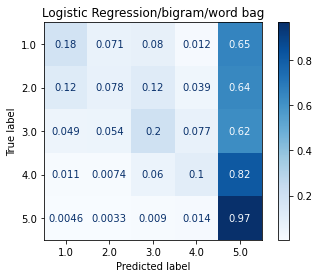

In [72]:
# confusion matrix
disp = plot_confusion_matrix(clf_bi, X_test_bi, y_test, 
                             cmap=plt.cm.Blues,
                             normalize = 'true')
plt.title('Logistic Regression/bigram/word bag')
plt.show()

#### 2.3 Logistic Regression/unigram/TFIDF

In [87]:
# training
lr_uni_tfidf = LogisticRegression(C=100, max_iter=2000)
clf_uni_tfidf = lr_uni_tfidf.fit(X_train_uni_tfidf, y_train)
y_train_pred = lr_uni_tfidf.predict(X_train_uni_tfidf)
print(accuracy(y_train_pred, y_train))

0.79342


In [88]:
# validation
# c = 10 max_iter = 10000 .74484 0.7163 0.7239
# c = 1 max_iter = 1000 0.74488 0.7168 0.7253
y_val_pred = lr_uni_tfidf.predict(X_val_uni_tfidf)
print(accuracy(y_val_pred, y_val))

0.7767


In [89]:
# testing
y_test_pred = lr_uni_tfidf.predict(X_test_uni_tfidf)
print(accuracy(y_test_pred, y_test))

0.7775


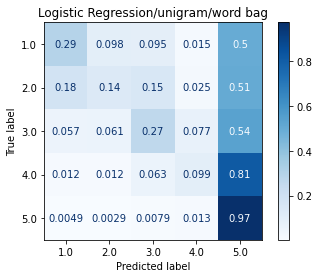

In [90]:
# confusion matrix

disp = plot_confusion_matrix(clf_uni_tfidf, X_test_uni_tfidf, y_test, 
                             cmap=plt.cm.Blues,
                             normalize = 'true')
plt.title('Logistic Regression/unigram/word bag')
plt.show()

#### 2.4 Logistic Regression/bigram/TFIDF

In [77]:
# testing
lr_bi_tfidf = LogisticRegression(C=100, max_iter=2000)
clf_bi_tfidf = lr_bi_tfidf.fit(X_train_bi_tfidf, y_train)
y_train_pred = lr_bi_tfidf.predict(X_train_bi_tfidf)
print(accuracy(y_train_pred , y_train))

0.78114


In [78]:
# validation
# c = 1 max_iter = 1000 0.72612 0.7021 0.7046
# c = 0.01 max_iter = 800 0.72612 0.7021 0.7046
# c = 0.01 max_iter = 800 0.71782 0.7074 0.7055
y_val_pred = lr_bi_tfidf.predict(X_val_bi_tfidf)
print(accuracy(y_val_pred , y_val))

0.7663


In [79]:
# testing
y_test_pred = lr_bi_tfidf.predict(X_test_bi_tfidf)
print(accuracy(y_test_pred, y_test))

0.7681


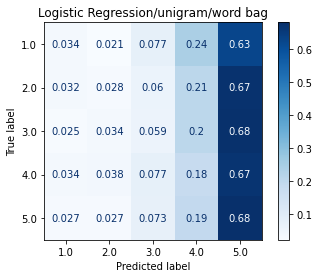

In [80]:
# confusion matrix
disp = plot_confusion_matrix(clf_uni_tfidf, X_test_bi_tfidf, y_test, 
                             cmap=plt.cm.Blues,
                             normalize = 'true')
plt.title('Logistic Regression/unigram/word bag')
plt.show()